# Part 4 - Visualizing time enabled data on the map widget

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Time-enabled-data" data-toc-modified-id="Time-enabled-data-1">Time-enabled data</a></span></li><li><span><a href="#Best-practices-when-adding-multiple-layers-to-a-map" data-toc-modified-id="Best-practices-when-adding-multiple-layers-to-a-map-2">Best practices when adding multiple layers to a map</a></span></li><li><span><a href="#Conclusion" data-toc-modified-id="Conclusion-3">Conclusion</a></span></li></ul></div>

## Time-enabled data

ArcGIS API for Python also supports visualizing time-enabled data on the map widget by setting the `time_slider` property and calling the `set_time_extent` method to initialize the `start_time`, `end_time`, `interval`, and `unit` arguments of the time filter.

`time_slider` is a property that determines whether a time slider exists for a map widget. If set to `True`, the property will display a time slider in the widget that will allow you to visualize temporal data for an applicable layer added to the map. Its default value is `False`.

The `set_time_extent` is called when `time_slider = True` and is the time extent that will display on the time slider. In order to properly call the method `set_time_extent(start_time, end_time, interval=1, unit='milliseconds')`, we need to specify the following arguments:  
 - `start_time`: Required ``datetime.datetime``. The lower bound of the time extent to display on the time slider.
 - `end_time`: Required ``datetime.datetime``. The upper bound of the time extent to display on the time slider.
 - `interval`: Optional number with a default of 1. The numerical value of the time extent.
 - `unit`: Optional string that defaults to milliseconds. Temporal units. Possible values can be seen in: “milliseconds”, “seconds”, “minutes”, “hours”, “days”, “weeks”, “months”, “years”, “decades”, “centuries”.

In [1]:
import arcgis
from arcgis.gis import GIS
# Create a GIS object, as an anonymous user for this example
gis = GIS()

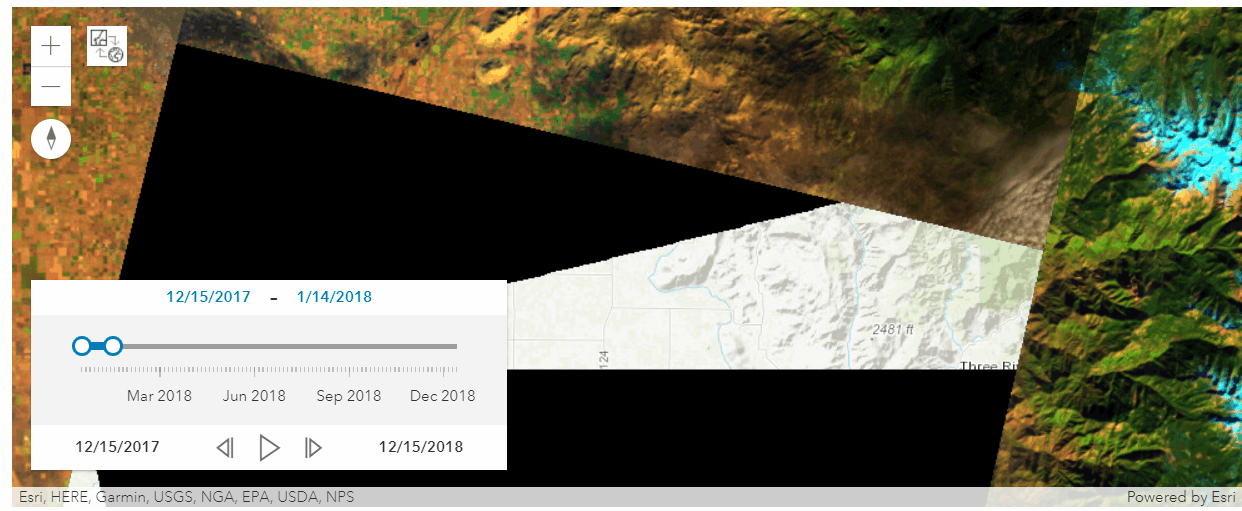

In [10]:
# Create a map widget
map8 = gis.map('California') # Passing a place name to the constructor
                        # will initialize the extent of the map.
map8

In [6]:
landsat_item = gis.content.search("Landsat Multispectral tags:'Landsat on AWS','landsat 8', 'Multispectral', 'Multitemporal', 'imagery', 'temporal', 'MS'", 'Imagery Layer', outside_org=True)[0]
print(landsat_item)

<Item title:"Multispectral Landsat" type:Imagery Layer owner:esri>


In [7]:
map8.add_layer(landsat_item)

In [8]:
map8.time_slider

False

In [9]:
from datetime import datetime
map8.time_slider = True
map8.set_time_extent(start_time=datetime(2017, 12, 15), end_time=datetime(2018, 12, 15), interval=10, unit='days')

## Best practices when adding multiple layers to a map

When it comes to adding multiple layers, especially large, complicated datasets, to the map widget, users often ask questions like:  
 - "Why is the map not showing anything other than the basemap while the Python Kernel is idle? This should mean the execution of the cell is finished?"
 - "When I render a list of 100+ layers onto the map widget in one cell, why are some layers missing from the display?"
 - "If I have layers A and B added to the map widget sequentially, why is layer B showing up first?"
 - "How do I know when a layer is finished rendering?"
 
To answer these questions, we have to trace back to the mechanism of how ArcGIS API for Javascript is rendering maps. When drawing on a map happens, a `LayerView` is created for every layer in the map. The `LayerView` takes care of what data it needs the layer to fetch and takes in the renderer information. It will then draw that data. For instance, if dealing with a `FeatureLayer`, you would have a `FeatureLayerView`. Now, if you are interested in when the data is done drawing on the map, the key is to watch for when the `layerView.updating` property becomes false. When it's false, the `LayerView` is done fetching data and done drawing on the map. There are a number of ways to check the `updating` property. For instance, you can use the `whenLayerView()` method or listen for the `layerview-create` event.

A sample JS code to watch for the event is shown below:
```
view.whenLayerView(featureLayer)
  .then((layerView) => {
    return watchUtils.whenFalseOnce(layerView, 'updating');
  })
  .then((newValue, oldValue, prop, layerView) => {
    console.log('layerView is done loading and drawing', layerView);
  });
```

One can also use `async/await` to check for status:
```
async function whenDone() {
  const layerView = await view.whenLayerView(featureLayer);
  await watchUtils.whenFalseOnce(layerView, 'updating');
  console.log('layerView is done loading and drawing', layerView);
}
```

In ArcGIS API for Python, an equivalent way to know if drawing is finished is to use the `ready` property of `MapView`. Here, `ready` is a read-only boolean that indicates whether the map widget has been drawn in the notebook. Because the Python kernel is released even before drawing is finished, simply checking the "idle kernel" sign is not useful in determining if the rendering of layers is completely finished.

As mentioned above, drawing on maps with ArcGIS API for Javascript is happening asynchronously. If a user adds a lot of layers in one cell, the orders of layers can get switched. This would make it even more difficult to determine which of the layers failed to draw, if there was a failure. As such, the best practice when adding multiple layers to a map is to add layers one by one sequentially.

A recommended approach would be like follows:
 - Create the map widget.
 - Load the target for display (Item, Layer, Service, etc.).
 - Insert a new cell and add layers one by one, rather than all together (This is only necessary if layer order is important).
 - When execution is finished, check the `ready` property to see if all layers have finished drawing. 

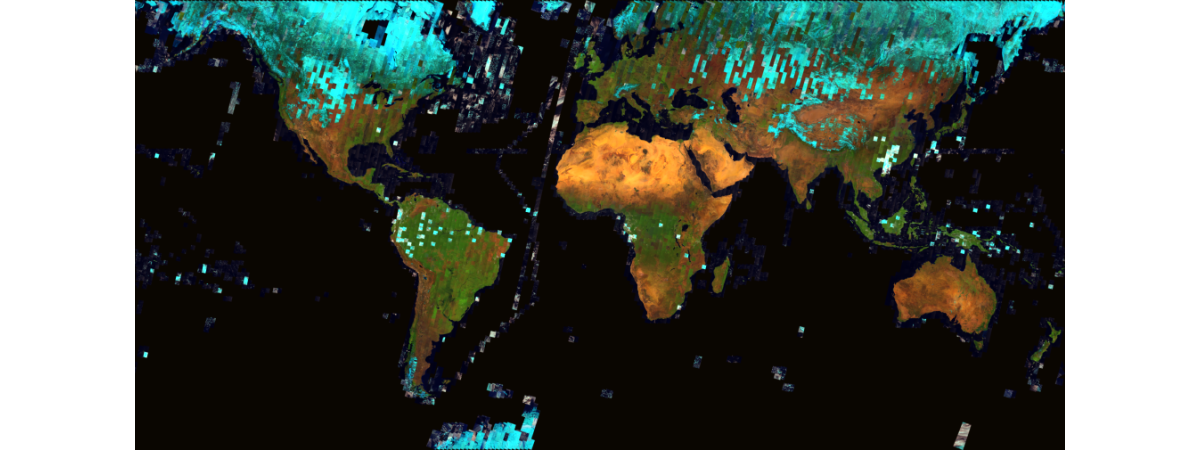

In [11]:
landsat = landsat_item.layers[0]
landsat

In [12]:
aoi = {'xmin': -117.58051663099998,
       'ymin': 33.43943880400006,
       'xmax': -114.77651663099998,
       'ymax': 36.243438804000064,
       'spatialReference': {'latestWkid': 4326, 'wkid': 102100},}

In [13]:
def select_image(start_time, end_time):
    [y1,m1,d1] = start_time
    [y2,m2,d2] = end_time
    selected = landsat.filter_by(where="(Category = 1) AND (CloudCover <=0.10)", 
                                       time=[datetime(y1,m1,d1), datetime(y2,m2,d2)],
                                       geometry=arcgis.geometry.filters.intersects(aoi))   
    return selected

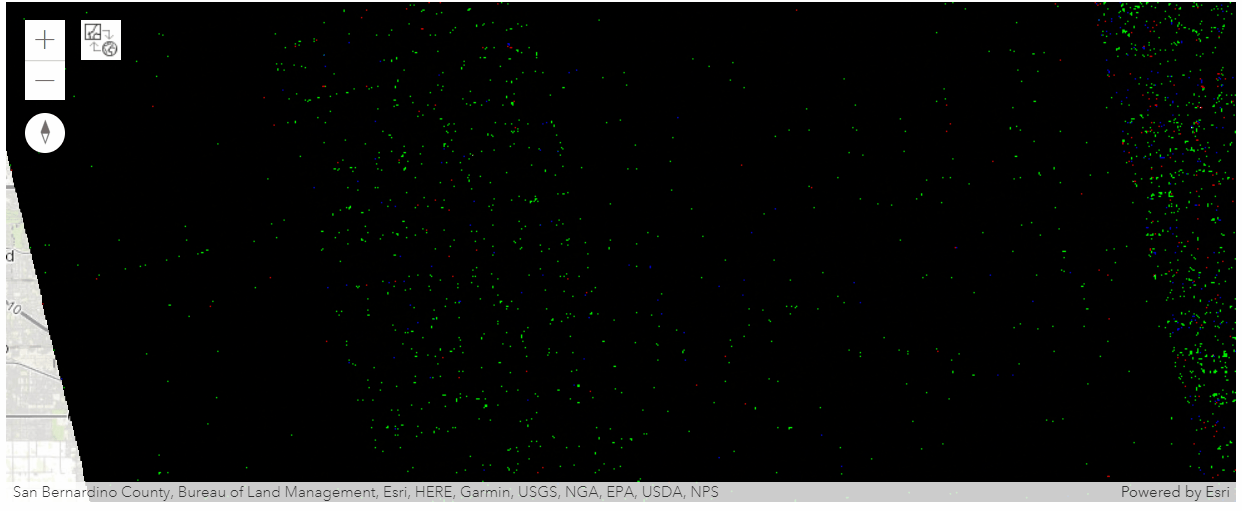

In [19]:
# Create a map widget
map9 = gis.map('San Bernadino, CA') # Passing a place name to the constructor
                        # will initialize the extent of the map.
map9

In [15]:
# Not recommended - 
# might cause slow-down, misorder, or loss of layers
for y in range(2000,2021):
    start_time=[y,12,1]
    end_time=[y+1,1,1]
    map9.add_layer(select_image(start_time, end_time))

In [16]:
map9.ready

True

A better way to implement the workflow above is to either add the 20 layers one by one (e.g. 1 layer per cell), rather than all in a for loop, or to check the `ready` property before adding each new layer.

In [17]:
map9.remove_layers()

True

In [18]:
# recommended
import time

for y in range(2000,2021):
    start_time=[y,12,1]
    end_time=[y+1,1,1]
    for count in range(0,10):
        if map9.ready:
            map9.add_layer(select_image(start_time, end_time))
            break
        elif count<9:
            time.sleep(5) # wait 5 sec
        else:
            print("Layer of Year " + str(y) + " has not finished drawing. Check back later!")

## Conclusion

In Part 4 of this guide series, we discussed the recommended approach for displaying time-enabled data. We also discussed the nature of drawing with the ArcGIS API for Javascript and the best practices when rendering a large number of layers in a single map widget. In the next chapter, we will explore how to save, export, and embed the map widget.

<a href="#Part-4---Visualizing-time-enabled-data-on-the-map-widget">Back to Top</a>